# BEE 4750 Homework 2: Dissolved Oxygen

**Name**: Jonathan Marcuse

**ID**: jrm564

> **Due Date**
>
> Friday, 09/22/23, 9:00pm

## Overview

### Instructions

This assignment asks you to use a simulation model for dissolved oxygen
to assess the impacts of two wastewater streams, including minimum
treatment levels and the impact of uncertain environmental conditions.
You will also be asked to identify a minimum distance for the addition
of a third discharge stream.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [30]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/Cornell/Fall2023/BEE4750/hw02-jrmarcuse`


In [31]:
using Plots
using LaTeXStrings
using Distributions

## Problems (Total: 40 Points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart, as shown in
<a href="#fig-river" class="quarto-xref">Figure 1</a>. The oxygen
reaeration rate is 0.55 day<sup>-1</sup>, and the decay rates of CBOD
and NBOD are are 0.35 and 0.25 day<sup>-1</sup>, respectively. The
river’s saturated dissolved oxygen concentration is 10m g/L.

![Figure 1: Schematic of the
system](attachment:figures/river_diagram.png)

### Problem 1 (8 points)

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

|    Parameter     |            River Inflow |         Waste Stream 1 |         Waste Stream 2 |
|:----------------:|------------------------:|-----------------------:|-----------------------:|
|      Inflow      | 100,000 L/d | 10,000 L/d | 15,000 L/d |
| DO Concentration |                7.5 mg/L |                 5 mg/L |                 5 mg/L |
|       CBOD       |                  5 mg/L |                50 mg/L |                45 mg/L |
|       NBOD       |                  5 mg/L |                35 mg/L |                35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

In [46]:
#Function to determine Dissolved Oxygen Concentration x distance downstream given 
#initial concentrations of DO, CBOD & NBOD in river and waste, and decay rate constants

    # x is distance downstream. Cs is saturated DO conc, C0 is initial DO conc, 
    #B0 is inital CBOD conc, N0 is initial NBOD conc, ka is oxygen reaeration rate, 
    #kc is CBOD decay constant, kn is NBOD decay constant, U is river flow velocity

function dissolved_oxygen(x, Cs, C0, B0, N0, ka, kc, kn, U)
    a1 = exp(-ka*x/U)
    a2 = (kc/(ka-kc))*(exp(-kc*x/U)-a1)
    a3=(kn/(ka-kn))*(exp(-kn*x/U)-a1)
    C=(Cs*(1-a1))+(C0*a1)-(B0*a2)-(N0*a3)
    return C
end

#Function to find initial state (C0) given a mixing of a waste stream and river

    #Cr is conc in River, Qr is flow rate of river
    #Cw is conc in Waste, Qw is flow rate of waste

function initial_state(Cr,Qr,Cw,Qw)
    Cm=(Cr*Qr+Cw*Qw)/(Qr+Qw)
    return Cm
end

#Function to calculate CBOD or NBOD as a function of distance, x
    #x is distance downstream, C0 is initial CBOD or NBOD conc,
    #k is decay rate constant, U is river velocity
function BOD_conc(x,C0,k,U)
    C = C0*exp(-1*k*x/U)
    return C
end

#Function for a river with two waste stream inputs that outputs the DO, CBOD and NBOD
#concentrations as a function of distance from the first waste stream input into the river

    #xf is the distance downstream you want the array to stop at,
    #Cs is saturated dissolved oxygen conc, d is distance between waste streams,
    #C0r is DO conc in river, B0r is CBOD conc in river, N0r is NBOD conc in river, 
    #Qr is river flow rate, #C0w1 is DO conc in waste 1, B0w1 is CBOD conc in waste 1, 
    #N0w1 is NBOD conc in waste 1, #Qw1 is waste1 flow rate, C0w2 is DO conc in waste 2, 
    #B0w2 is CBOD conc in waste 2, N0w2 is NBOD conc in waste 2, Qw2 is waste2 flow rate,
    #ka is oxygen reaeration rate, kc is CBOD decay constant, kn is NBOD decay constant, 
    #U is river flow velocity, x_step is the distance for every DO conc calculation

function two_waste_streams(xf,Cs,d,C0r,B0r,N0r,Qr,C0w1,B0w1,N0w1,Qw1,C0w2,B0w2,N0w2,Qw2,ka,kc,kn,U,x_step)
    #first get mixed concentration at x=0 where waste stream 1 is released
    C1= initial_state(C0r,Qr,C0w1,Qw1);
    B1= initial_state(B0r,Qr,B0w1,Qw1);
    N1= initial_state(N0r,Qr,N0w1,Qw1);

    #Then make list of values for DO, CBOD and NBOD conc from x=0 to x=d
    DO_C = [dissolved_oxygen(x,Cs,C1,B1,N1,ka,kc,kn,U) for x in 0:x_step:d];
    CBOD_C= [BOD_conc(x,B1,kc,U) for x in 0:x_step:d];
    NBOD_C= [BOD_conc(x,N1,kn,U) for x in 0:x_step:d];

    #Gets mixed concentration at x=d, where waste 2 is released
    C2= initial_state(DO_C[length(DO_C)],Qr+Qw1,C0w2,Qw2);
    B2= initial_state(CBOD_C[length(CBOD_C)],Qr+Qw1,B0w2,Qw2); #NEED CBOD AND NBOD CONCS
    N2= initial_state(NBOD_C[length(NBOD_C)],Qr+Qw1,N0w2,Qw2);

    #Then make list of values for DO, CBOD and NBOD conc from x=d to x=xf

    DO_C2 = [dissolved_oxygen(x,Cs,C2,B2,N2,ka,kc,kn,U) for x in 0:x_step:(xf-d)];
    CBOD_C2= [BOD_conc(x,B2,kc,U) for x in 0:x_step:(xf-d)];
    NBOD_C2= [BOD_conc(x,N2,kn,U) for x in 0:x_step:(xf-d)];

    #Remove last value in these vectors as they will be the same as the first value in the second vector
    DO_C = DO_C[1:end-1];
    CBOD_C = CBOD_C[1:end-1];
    NBOD_C = NBOD_C[1:end-1];

    #Stitch together the values from between the two waste streams and 
    #after the second waste stream
    DO_C = append!(DO_C,DO_C2);
    CBOD_C = append!(CBOD_C,CBOD_C2);
    NBOD_C = append!(NBOD_C,NBOD_C2);
    
    #Plot the DO, CBOD and NBOD concentrations on the same graph with x-values for distance
    x_values = 0:x_step:xf
    P = plot(x_values,DO_C,label="DO")
    plot!(x_values,CBOD_C,label="CBOD")
    plot!(x_values,NBOD_C,label="NBOD")
    xlabel!("Distance Downstream (km)")
    ylabel!("Concentration (mg/L)")
    title!("Distance vs Concentration")
    #And a separate plot just for dissolved oxygen
    P1 = plot(x_values,DO_C,label="DO",xlabel="Distance Downstream (km)",
    ylabel="Concentration (mg/L)",title="Distance vs Concentration")


    return DO_C, CBOD_C, NBOD_C, P, P1

end

two_waste_streams (generic function with 1 method)

### Problem 2 (4 points)

Use your model to plot the dissolved oxygen concentration in the river
from the first waste stream to 50km downstream. What do you notice?

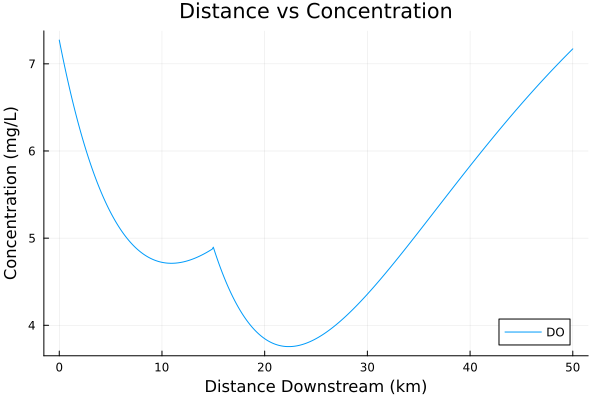

In [48]:
#Call the function with all necessary inputs and then display the plot containing just the DO curve
DO_C, CBOD_C, NBOD_C, P, P1 = two_waste_streams(50,10,15,7.5,5,5,100000,5,50,35,10000,5,45,35,15000,0.55,0.35,0.25,6,0.1);
display(P1)

The DO concentration curves are continuos and the pattern shifts once the second waste stream is introduced. After each waste stream the DO levels dip down and begin to recover after a certain distance downstream.

### Problem 3 (3 points)

Under the assumptions of Problem 1, determine the distance from waste
stream 2 it will take for the dissolved oxygen concentration of the
river to recover to 6 mg/L.

In [50]:
DO_C, CBOD_C, NBOD_C, P, P1 = two_waste_streams(50,10,15,7.5,5,5,100000,5,50,35,10000,5,45,35,15000,0.55,0.35,0.25,6,0.1);

#initialize i at the start of waste stream 2
i=150; #it is 10 times the amount due to the 0.1 x_step
while DO_C[i]<=6
    i=i+1
end

#calculate distance from waste stream 2
d=(i/10)-15;
return d

26.299999999999997

It will take 26.3km downstream of waste stream 2 for the DO to recover to a concentration of 6 mg/L.

### Problem 4 (5 points)

What is the minimum level of treatment (% removal of organic waste) for
waste stream 2 that will ensure that the dissolved oxygen concentration
never drops below 4 mg/L, assuming that waste stream 1 remains
untreated?

In [57]:
# % removal variable for organics in waste stream 2
#initialize while loop and percent removal variable
achieved=0;
pr=1; #This is actually a percent kept, percent removal is 1-pr

while achieved==0
    #total organics is a % removal of CBOD and NBOD for waste 1 inputs
    DO_C, CBOD_C, NBOD_C, P, P1 = two_waste_streams(50,10,15,7.5,5,5,100000,5,50,35,10000,5,pr*45,pr*35,15000,0.55,0.35,0.25,6,0.1);
    if any(x -> x<4, DO_C) #check to see if any values in the DO vector are less than 4
        pr=pr-0.001; #if it is then reiterate with a greater percentage of removal
    else
        achieved=1;
    end
end

return 1-pr


0.1180000000000001

About 11.8% of the organics in waste stream 2 need to be removed to never have the DO concentration dip below 4mg/L

### Problem 5 (5 points)

If both waste streams are treated equally, what is the minimum level of
treatment (% removal of organic waste) for the two sources required to
ensure that the dissolved oxygen concentration never drops below 4 mg/L?

In [58]:
# % removal variable for organics in waste stream 2
#initialize while loop and percent removal variable
achieved=0;
pr=1; #This is actually a percent kept, percent removal is 1-pr

while achieved==0
    #total organics is a % removal of CBOD and NBOD for both waste 1 and waste 2 inputs
    DO_C, CBOD_C, NBOD_C, P, P1 = two_waste_streams(50,10,15,7.5,5,5,100000,5,pr*50,pr*35,10000,5,pr*45,pr*35,15000,0.55,0.35,0.25,6,0.1);
    if any(x -> x<4, DO_C) #check to see if any values in the DO vector are less than 4
        pr=pr-0.001; #if it is then reiterate with a greater percentage of removal
    else
        achieved=1;
    end
end

return 1-pr


0.06600000000000006

The minimum % of removal if both waste streams are treated equally is 6.6% removed from each stream

### Problem 6 (5 points)

Suppose you are responsible for designing a waste treatment plan for
discharges into the river, with a regulatory mandate to keep the
dissolved oxygen concentration above 4 mg/L. Discuss whether you’d opt
to treat waste stream 2 alone or both waste streams equally. What other
information might you need to make a conclusion, if any?

I would like to know the cost of removing a certain percentage of organics. The total amount of organics that would need to be removed if just treating waste stream 2 is 0.118*(35+45) which is a total of 9.44 mg/L whereas if both streams are considered it is 0.066*(50+35+45+35) which is a total of 10.89 mg/L of organic waste that needs to be removed. So if the cost is only a function of total organics removed I would choose to only treat the second waste stream. If the process of removing organics becomes increasingly more expensive per percent that you are removing, then maybe it would be cheaper to remove less from two separate streams than more from a single stream. And, if that was the case I would choose to remove from both waste streams.

### Problem 7 (5 points)

Suppose that it is known that the DO concentrations at the river inflow
can vary uniformly between 6 mg/L and 8 mg/L. How often will the
treatment plan identified in Problem 5 (both waste streams treated
equally) fail to comply with the regulatory standard?

In [60]:
pr = 1-0.066; #percent kept
count=0; #number of times it fails
count_i=0; #number of trials

for C0=6:0.01:8 #iterate the DO fluctuation from 6 to 8
    DO_C, CBOD_C, NBOD_C, P, P1 = two_waste_streams(50,10,15,C0,5,5,100000,5,pr*50,pr*35,10000,5,pr*45,pr*35,15000,0.55,0.35,0.25,6,0.1);
    if any(x -> x<4, DO_C) #tests if the treatment fails
        count=count+1;
    end
    count_i=count_i+1;
end

prob = count/count_i; #percent of times it fails

return prob

0.736318407960199

The treatment will fail 73.6% of the time if the DO experiences this fluctuation using the treatment method from question 5.

### Problem 8 (5 points)

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5000
L/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

Assume that the treatment plan you identified in Problem 5 is still in
place for the existing discharges. If the third discharge will not be
treated, under the original inflow conditions (7.5 mg/L DO), how far
downstream from the second discharge does this third discharge need to
be placed to keep the river concentration from dropping below 4 mg/L?

In [82]:
#Function for a river with three waste stream inputs that outputs the DO, CBOD and NBOD 
#concentrations as a function of distance from the first waste stream input into the river

    #xf is the distance downstream you want the array to stop at,
    #Cs is saturated dissolved oxygen conc, d is distance between waste streams,
    #C0r is DO conc in river, B0r is CBOD conc in river, N0r is NBOD conc in river, 
    #Qr is river flow rate, #C0w1 is DO conc in waste 1, B0w1 is CBOD conc in waste 1, 
    #N0w1 is NBOD conc in waste 1, #Qw1 is waste1 flow rate, C0w2 is DO conc in waste 2, 
    #B0w2 is CBOD conc in waste 2, N0w2 is NBOD conc in waste 2, Qw2 is waste2 flow rate,
    #ka is oxygen reaeration rate, kc is CBOD decay constant, kn is NBOD decay constant, 
    #U is river flow velocity, x_step is the distance for every DO conc calculation
    #C0w3 is DO conc in waste 3, B0w3 is CBOD conc in waste 3, N0w3 is NBOD conc in waste 3, 
    #Qw3 is waste3 flow rate, d2 is distance between waste stream 2 and 3

function three_waste_streams(xf,Cs,d,C0r,B0r,N0r,Qr,C0w1,B0w1,N0w1,Qw1,C0w2,B0w2,N0w2,Qw2,ka,kc,kn,U,x_step,C0w3,B0w3,N0w3,Qw3,d2)
    #first get mixed concentration at x=0 where waste stream 1 is released
    C1= initial_state(C0r,Qr,C0w1,Qw1);
    B1= initial_state(B0r,Qr,B0w1,Qw1);
    N1= initial_state(N0r,Qr,N0w1,Qw1);

    #Then make list of values for DO, CBOD and NBOD conc from x=0 to x=d
    DO_C = [dissolved_oxygen(x,Cs,C1,B1,N1,ka,kc,kn,U) for x in 0:x_step:d];
    CBOD_C= [BOD_conc(x,B1,kc,U) for x in 0:x_step:d];
    NBOD_C= [BOD_conc(x,N1,kn,U) for x in 0:x_step:d];

    #Gets mixed concentration at x=d, where waste 2 is released
    C2= initial_state(DO_C[length(DO_C)],Qr+Qw1,C0w2,Qw2);
    B2= initial_state(CBOD_C[length(CBOD_C)],Qr+Qw1,B0w2,Qw2);
    N2= initial_state(NBOD_C[length(NBOD_C)],Qr+Qw1,N0w2,Qw2);

    #Then make list of values for DO, CBOD and NBOD conc from x=d to x=xf

    DO_C2 = [dissolved_oxygen(x,Cs,C2,B2,N2,ka,kc,kn,U) for x in 0:x_step:d2]; 
    CBOD_C2= [BOD_conc(x,B2,kc,U) for x in 0:x_step:d2];
    NBOD_C2= [BOD_conc(x,N2,kn,U) for x in 0:x_step:d2];
    
    ## Added piece for Q8 ##
    #Gets mixed concentration at x=d2, where waste 3 is released
    C3= initial_state(DO_C2[length(DO_C2)],Qr+Qw1+Qw2,C0w3,Qw3);
    B3= initial_state(CBOD_C2[length(CBOD_C2)],Qr+Qw1+Qw2,B0w3,Qw3);
    N3= initial_state(NBOD_C2[length(NBOD_C2)],Qr+Qw1+Qw2,N0w3,Qw3);

    #Then make list of values for DO, CBOD and NBOD conc from x=d2 to x=xf

    DO_C3 = [dissolved_oxygen(x,Cs,C3,B3,N3,ka,kc,kn,U) for x in 0:x_step:(xf-d-d2)];
    CBOD_C3= [BOD_conc(x,B3,kc,U) for x in 0:x_step:(xf-d-d2)];
    NBOD_C3= [BOD_conc(x,N3,kn,U) for x in 0:x_step:(xf-d-d2)];
    ## End of added piece for Q8 ##

    #Remove last value in these vectors as they will be the same as the first value in the next vector
    DO_C = DO_C[1:end-1];
    CBOD_C = CBOD_C[1:end-1];
    NBOD_C = NBOD_C[1:end-1];
    ## Added piece for Q8 ##
    DO_C2 = DO_C2[1:end-1];
    CBOD_C2 = CBOD_C2[1:end-1];
    NBOD_C2 = NBOD_C2[1:end-1];

    #To append 3 vectors need to create a target vector and append each separately
    DO_C0 = [] 
    append!(DO_C0,DO_C);
    append!(DO_C0,DO_C2);
    append!(DO_C0,DO_C3);

    CBOD_C0 = []
    append!(CBOD_C0,CBOD_C);
    append!(CBOD_C0,CBOD_C2);
    append!(CBOD_C0,CBOD_C3);

    NBOD_C0 = []
    append!(NBOD_C0,NBOD_C);
    append!(NBOD_C0,NBOD_C2);
    append!(NBOD_C0,NBOD_C3);
    ## End of added piece for Q8 ##

    #Plot the DO, CBOD and NBOD concentrations on the same graph with x-values for distance
    x_values = 0:x_step:xf
    P = plot(x_values,DO_C0,label="DO")
    plot!(x_values,CBOD_C0,label="CBOD")
    plot!(x_values,NBOD_C0,label="NBOD")
    xlabel!("Distance Downstream (km)")
    ylabel!("Concentration (mg/L)")
    title!("Distance vs Concentration")
    #And a separate plot just for dissolved oxygen
    P1 = plot(x_values,DO_C0,label="DO",xlabel="Distance Downstream (km)",
    ylabel="Concentration (mg/L)",title="Distance vs Concentration")

    return DO_C0, CBOD_C0, NBOD_C0, P, P1

end


three_waste_streams (generic function with 1 method)

In [85]:
pr=1-0.066; #percent kept
d2=0; #initialize distance
achieved=0;

while achieved==0
    DO_C, CBOD_C, NBOD_C, P, P1 = 
    three_waste_streams(50,10,15,C0,5,5,100000,5,pr*50,pr*35,10000,5,pr*45,pr*35,15000,0.55,0.35,0.25,6,0.1,4.5,50,45,5000,d2);
    #check to see if at any point DO falls below 4
    if any(x -> x<4, DO_C)
        d2=d2+0.1; #iterate distance to be greater if it fails
    else
        achieved=1;
    end
end

return d2

## References

List any external references consulted, including classmates.